# 气象绘图之 ---- 白化

白化：我们使用的气象数据一般是栅格的形式，比如MODIS卫星数据，再分析数据，有时候我们并不想绘制一个矩形区域的数据，想要一个特定的边界----比如中国，或是某一个具体的省份，这时候就需要白化来帮助我们绘制想要的形状了  
关于白化我目前了解有四种方法：  
1.**cnmaps**的get_adm_maps方法，该方法可以获取某省的具体边界，省去了寻找shape文件的麻烦  
2.使用**maskout.py**这个模块，其中的函数shp2clip_new(originfig, ax, shpfile, clabel=None,vcplot=None)可帮助我们绘制想要的shape  
3.**salem**库，这个方法比较简单，通过.salem.roi(shape= )这个方法可以更具shape文件来筛选数据  
4.**polygon_to_mask**，可生成掩膜数组，为布尔值，可根据该布尔数组筛选数据。 
  
下面我们来逐一尝试下

## cnmaps
关于cnmaps的具体用法可以参考该[文档](https://cnmaps.readthedocs.io/zh_CN/latest/index.html)  
我们使用[CHM_PRE数据集](https://data.tpdc.ac.cn/zh-hans/data/e5c335d9-cbb9-48a6-ba35-d67dd614bb8c)  
数据描述：CHM_PRE数据集基于中国境内及周边1961至今共2839个站点的日降水观测，在传统的“降水背景场 + 降水比值场”的数据集构建思路上，尝试应用月值降水约束和地形特征校正，并依据中国范围内约4万个高密度站点2015–2019年的日降水量插值后数据进行精度评价。经评估认为，CHM_PRE可以较好的表征降水的空间变异性，其日值时间序列与高密度站点日值降水观测结果之间的相关系数中位数为0.78，均方根误差中位数为8.8 mm/d，KGE值中位数为0.69，与目前常用的降水数据集（CGDPA、CN05.1、CMA V2.0）有很好的一致性。 数据集的时间范围为1961年至今，空间分辨率为0.1°、0.25°和0.5°，经纬度范围为18°N–54°N, 72°E–136°E


In [1]:
"""导入相关库"""
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cnmaps import get_adm_maps,get_adm_names,clip_contours_by_map,draw_map,draw_maps
import xarray as xr
import numpy as np
import cnmaps
import cmaps

"""读取数据，经纬度"""
df = xr.open_dataset('/mnt/f/data_CHM_PRE/CHM_PRE_0.5dg_19612022.nc')
pre = df['pre']
lat = df['latitude']
lon = df['longitude']
df

<xarray.Dataset>
Dimensions:         (longitude: 128, latitude: 72, years: 62, time: 22645)
Coordinates:
  * longitude       (longitude) float64 72.25 72.75 73.25 ... 134.8 135.2 135.8
  * latitude        (latitude) float64 18.25 18.75 19.25 ... 52.75 53.25 53.75
  * years           (years) float64 1.961e+03 1.962e+03 ... 2.021e+03 2.022e+03
  * time            (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
Data variables:
    pre             (time, latitude, longitude) float32 ...
    station_number  (years, latitude, longitude) float32 ...
Attributes:
    Title:               IDW + PRISM: China gridded daily precipitation
    Institution:         Data held at Beijing Normal University, China
    History:             Last updated on 30-Apr-2023
    Time scale:          1961-01-01 to 2022-12-31
    Time resolution:     daily
    Spatial extent:      18°N–54°N, 72°E–136°E
    Spatial resolution:  0.5° × 0.5°
    Contact:             miaocy@bnu.edu.cn

/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/cnmaps/maps.py:443: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf["geometry"] = map_polygons
/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/cnmaps/maps.py:443: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Curre

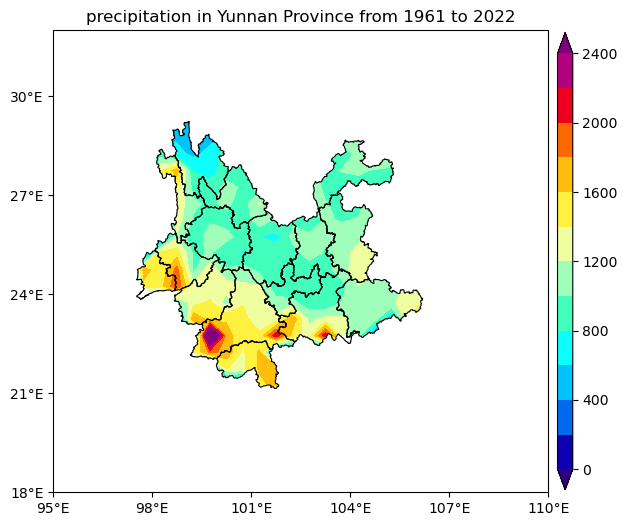

In [2]:
pre = np.mean(pre,axis=0)*365
pre = np.array(pre)
pre[pre<0]=np.nan
lon,lat = np.meshgrid(lon, lat) #绘制二维网格
"""设置绘图区域， 投影"""
fig, ax1 = plt.subplots(figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()})

"""设置经纬度范围"""
left_lon, right_lon, lower_lat, upper_lat = (95, 110, 18, 32)
img_extent = [left_lon, right_lon, lower_lat, upper_lat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())


ax1.set_title('precipitation in Yunnan Province from 1961 to 2022')
ax1.set_xticks(np.arange(img_extent[0],img_extent[1]+1,3),crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(img_extent[2],img_extent[3]+1,3),crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax1.yaxis.set_major_formatter(LongitudeFormatter())

"""添加等值线和colobar"""
cs = ax1.contourf(lon,lat,pre,zorder=1,levels=np.arange(0,2600,200),transform=ccrs.PlateCarree(),cmap=cmaps.NCV_jaisnd,extend='both')
cbar = plt.colorbar(cs,shrink=0.99,aspect=30,fraction=0.3,pad=0.01)
cbar.set_ticks(np.arange(0,2600,400))

draw_maps(get_adm_maps(province='云南省', level='市'), color='black', linewidth=0.8)  #绘制省内各区边界
map_polygon = get_adm_maps(province='云南省', level='市', only_polygon=True)    #获取云南省边界多边形
clip_contours_by_map(cs,map_polygon)  

plt.show()


## maskout.py
该方法比较简单，我提供一个如下的maskout代码（这份代码经过许多位大佬的完善，感谢大佬们的开发）

In [3]:
import shapefile
from matplotlib.path import Path
from matplotlib.patches import PathPatch
def shp2clip_new(originfig, ax, shpfile, clabel=None,vcplot=None):
    """
    根据shapefile白化
    clabel为plt.clabel()返回的对象
    vcplot为逻辑变量
    """
    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        ####这里需要找到和region匹配的唯一标识符，record[]中必有一项是对应的。
        # if shape_rec.record[3] == region:   #####在country1.shp上，对中国以外的其他国家或地区进行maskout
        # region_name = shape_rec.record[3]
        # if region_name in regionlist: 
        pts = shape_rec.shape.points
        prt = list(shape_rec.shape.parts) + [len(pts)]
        for i in range(len(prt) - 1):
            for j in range(prt[i], prt[i+1]):
                vertices.append((pts[j][0], pts[j][1]))
            codes += [Path.MOVETO]
            codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
            codes += [Path.CLOSEPOLY]
        clip = Path(vertices, codes)
        clip = PathPatch(clip, transform=ax.transData)

    if vcplot:
        # 判断风矢量返回值是否可迭代
        if isinstance(originfig,Iterable):
            for ivec in originfig:
                ivec.set_clip_path(clip)
        else:
            originfig.set_clip_path(clip)
    else:
        for contour in originfig.collections:
            contour.set_clip_path(clip)
    if clabel:
        clip_map_shapely = ShapelyPolygon(vertices)
        for text_object in clabel:
            if not clip_map_shapely.contains(ShapelyPoint(text_object.get_position())):
                text_object.set_visible(False)  
    return clip

/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


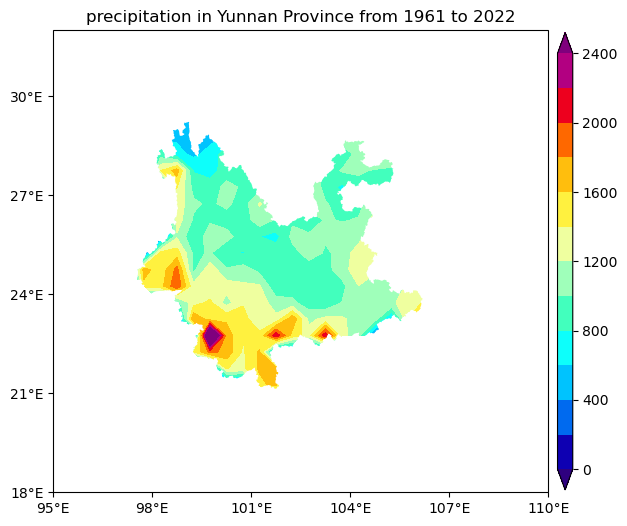

In [4]:
"""导入相关库"""
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cnmaps import get_adm_maps,get_adm_names,clip_contours_by_map,draw_map,draw_maps
import xarray as xr
import numpy as np
import cnmaps
import cmaps
"""提供shapefile的路径"""
shp_path = '/mnt/f/shape_data/yunnan_province_shapefile/yunnan_province_shapefile.shp'

"""读取数据，经纬度"""
df = xr.open_dataset('/mnt/f/data_CHM_PRE/CHM_PRE_0.5dg_19612022.nc')
pre = df['pre']
lat = df['latitude']
lon = df['longitude']

pre = np.mean(pre,axis=0)*365
pre = np.array(pre)
pre[pre<0]=np.nan
lon,lat = np.meshgrid(lon, lat) #绘制二维网格
"""设置绘图区域， 投影"""
fig, ax1 = plt.subplots(figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()})

"""设置经纬度范围"""
left_lon, right_lon, lower_lat, upper_lat = (95, 110, 18, 32)
img_extent = [left_lon, right_lon, lower_lat, upper_lat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())


ax1.set_title('precipitation in Yunnan Province from 1961 to 2022')
ax1.set_xticks(np.arange(img_extent[0],img_extent[1]+1,3),crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(img_extent[2],img_extent[3]+1,3),crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax1.yaxis.set_major_formatter(LongitudeFormatter())

"""添加等值线和colobar"""
cs = ax1.contourf(lon,lat,pre,zorder=1,levels=np.arange(0,2600,200),transform=ccrs.PlateCarree(),cmap=cmaps.NCV_jaisnd,extend='both')
cbar = plt.colorbar(cs,shrink=0.99,aspect=30,fraction=0.3,pad=0.01)
cbar.set_ticks(np.arange(0,2600,400))

shp2clip_new(cs,ax1,shp_path)  #裁剪

plt.show()

## salem库  
这也方法也比较简单，缺点是对数据精度要求较高，以及salem的安装较为复杂，推荐在虚拟机上使用。该库需要辅以geopandas

/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


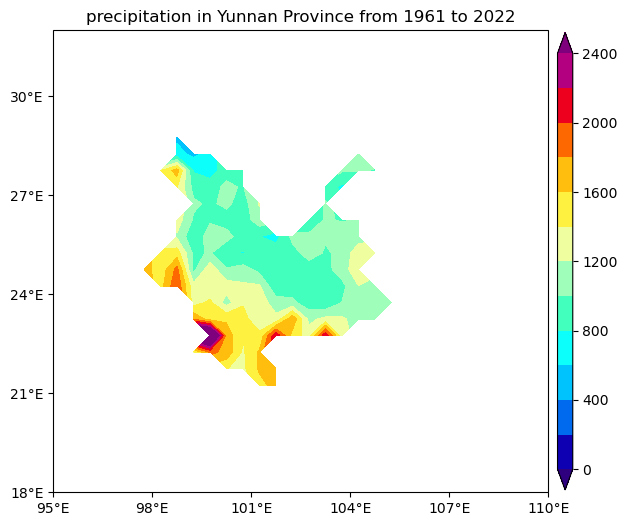

In [6]:
"""导入相关库"""
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cnmaps import get_adm_maps,get_adm_names,clip_contours_by_map,draw_map,draw_maps
import xarray as xr
import numpy as np
import cnmaps
import cmaps
import salem
import geopandas
"""提供shapefile的路径"""
shp_path = '/mnt/f/shape_data/yunnan_province_shapefile/yunnan_province_shapefile.shp'
shp = geopandas.read_file(shp_path)
"""读取数据，经纬度"""
df = xr.open_dataset('/mnt/f/data_CHM_PRE/CHM_PRE_0.5dg_19612022.nc')
pre = df['pre'].salem.roi(shape=shp)  #利用salem获取云南省内的数据
lat = df['latitude']
lon = df['longitude']

pre = np.mean(pre,axis=0)*365
pre = np.array(pre)
pre[pre<0]=np.nan
lon,lat = np.meshgrid(lon, lat) #绘制二维网格
"""设置绘图区域， 投影"""
fig, ax1 = plt.subplots(figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()})

"""设置经纬度范围"""
left_lon, right_lon, lower_lat, upper_lat = (95, 110, 18, 32)
img_extent = [left_lon, right_lon, lower_lat, upper_lat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())


ax1.set_title('precipitation in Yunnan Province from 1961 to 2022')
ax1.set_xticks(np.arange(img_extent[0],img_extent[1]+1,3),crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(img_extent[2],img_extent[3]+1,3),crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax1.yaxis.set_major_formatter(LongitudeFormatter())

"""添加等值线和colobar"""
cs = ax1.contourf(lon,lat,pre,zorder=1,levels=np.arange(0,2600,200),transform=ccrs.PlateCarree(),cmap=cmaps.NCV_jaisnd,extend='both')
cbar = plt.colorbar(cs,shrink=0.99,aspect=30,fraction=0.3,pad=0.01)
cbar.set_ticks(np.arange(0,2600,400))


plt.show()

## polygon_to_mask
该方法由微信公众号气象备忘录发表  
原理是通过polygon_to_mask这个函数获取掩膜数组，通过该数组可直接对数据进行筛选  
下面是polygon_to_mask的源码  
使用ploygon_to_mask 需要配合shapefile与shapely.geometry获取传递参数

In [7]:
from cnmaps import get_adm_maps
import xarray as xr
import shapely.geometry as sgeom
from shapely.prepared import prep
import math

def polygon_to_mask(polygon, x, y):
    '''生成落入多边形的点的掩膜数组.'''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    if x.shape != y.shape:
        raise ValueError('x和y的形状不匹配')
    prepared = prep(polygon)

    def recursion(x, y):
        '''递归判断坐标为x和y的点集是否落入多边形中.'''
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        xflag = math.isclose(xmin, xmax)
        yflag = math.isclose(ymin, ymax)
        mask = np.zeros(x.shape, dtype=bool)

        # 散点重合为单点的情况.
        if xflag and yflag:
            point = sgeom.Point(xmin, ymin)
            if prepared.contains(point):
                mask[:] = True
            else:
                mask[:] = False
            return mask

        xmid = (xmin + xmax) / 2
        ymid = (ymin + ymax) / 2

        # 散点落在水平和垂直直线上的情况.
        if xflag or yflag:
            line = sgeom.LineString([(xmin, ymin), (xmax, ymax)])
            if prepared.contains(line):
                mask[:] = True
            elif prepared.intersects(line):
                if xflag:
                    m1 = (y >= ymin) & (y <= ymid)
                    m2 = (y >= ymid) & (y <= ymax)
                if yflag:
                    m1 = (x >= xmin) & (x <= xmid)
                    m2 = (x >= xmid) & (x <= xmax)
                if m1.any(): mask[m1] = recursion(x[m1], y[m1])
                if m2.any(): mask[m2] = recursion(x[m2], y[m2])
            else:
                mask[:] = False
            return mask

        # 散点可以张成矩形的情况.
        box = sgeom.box(xmin, ymin, xmax, ymax)
        if prepared.contains(box):
            mask[:] = True
        elif prepared.intersects(box):
            m1 = (x >= xmid) & (x <= xmax) & (y >= ymid) & (y <= ymax)
            m2 = (x >= xmin) & (x <= xmid) & (y >= ymid) & (y <= ymax)
            m3 = (x >= xmin) & (x <= xmid) & (y >= ymin) & (y <= ymid)
            m4 = (x >= xmid) & (x <= xmax) & (y >= ymin) & (y <= ymid)
            if m1.any(): mask[m1] = recursion(x[m1], y[m1])
            if m2.any(): mask[m2] = recursion(x[m2], y[m2])
            if m3.any(): mask[m3] = recursion(x[m3], y[m3])
            if m4.any(): mask[m4] = recursion(x[m4], y[m4])
        else:
            mask[:] = False

        return mask

    return recursion(x, y)

/home/chenzhe/miniconda3/envs/env1/lib/python3.8/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


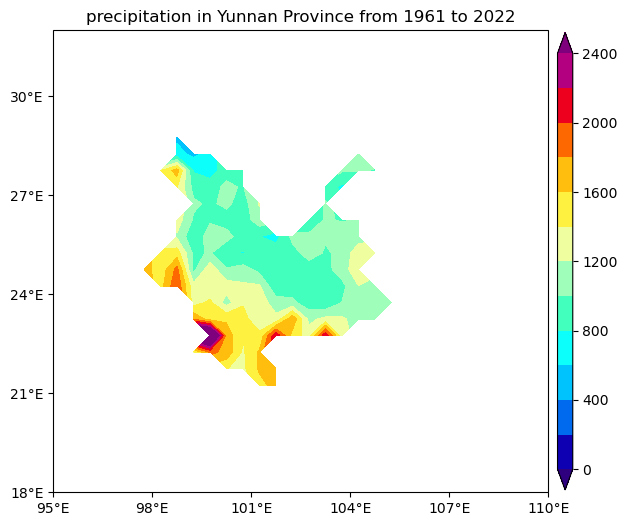

In [11]:
"""导入相关库"""
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cnmaps import get_adm_maps,get_adm_names,clip_contours_by_map,draw_map,draw_maps
import xarray as xr
import numpy as np
import cnmaps
import cmaps
import shapefile
import shapely.geometry as sgeom

"""提供shapefile的路径"""
shp_path = '/mnt/f/shape_data/yunnan_province_shapefile/yunnan_province_shapefile.shp'
shp = shapefile.Reader(shp_path)
yunnan = sgeom.shape(shp.shapes())
"""读取数据，经纬度"""
df = xr.open_dataset('/mnt/f/data_CHM_PRE/CHM_PRE_0.5dg_19612022.nc')
pre = df['pre']
lat = df['latitude']
lon = df['longitude']
lon,lat = np.meshgrid(lon, lat) #绘制二维网格
mask = polygon_to_mask(yunnan,lon,lat)

pre = np.mean(pre,axis=0)*365
pre = pre.where(mask)
pre = np.array(pre)
pre[pre<0]=np.nan
"""设置绘图区域， 投影"""
fig, ax1 = plt.subplots(figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()})

"""设置经纬度范围"""
left_lon, right_lon, lower_lat, upper_lat = (95, 110, 18, 32)
img_extent = [left_lon, right_lon, lower_lat, upper_lat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())


ax1.set_title('precipitation in Yunnan Province from 1961 to 2022')
ax1.set_xticks(np.arange(img_extent[0],img_extent[1]+1,3),crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(img_extent[2],img_extent[3]+1,3),crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax1.yaxis.set_major_formatter(LongitudeFormatter())

"""添加等值线和colobar"""
cs = ax1.contourf(lon,lat,pre,zorder=1,levels=np.arange(0,2600,200),transform=ccrs.PlateCarree(),cmap=cmaps.NCV_jaisnd,extend='both')
cbar = plt.colorbar(cs,shrink=0.99,aspect=30,fraction=0.3,pad=0.01)
cbar.set_ticks(np.arange(0,2600,400))


plt.show()

# 小结
如最终图所示，maskout与cnmaps都是对原始的整个中国区域的等值线进行裁剪，边界较为清晰，而salem与polygon_to_mask则是对原始的数据进行筛选后再绘图，边界较为粗糙，与数据精度有较大关联。  
